### Construccion de Dataset

Comenzamos por agrupar imagenes en carpetas por clase

In [35]:
import os
import shutil

# Ruta de la carpeta con las imágenes
carpeta_imagenes = '..\data\prepared_data\\raw_images'

# Crear una carpeta para cada clase y mover las imágenes
for nombre_archivo in os.listdir(carpeta_imagenes):
    # Ignorar archivos que no sean imágenes (opcional)
    if not nombre_archivo.endswith(('.jpg', '.jpeg', '.png')):
        continue

    # Extraer la clase del nombre del archivo (todo antes del último guion bajo)
    clase = '_'.join(nombre_archivo.split('_')[:-2])

    # Ruta de la carpeta de clase
    carpeta_clase = os.path.join(carpeta_imagenes, clase)

    # Crear la carpeta si no existe
    if not os.path.exists(carpeta_clase):
        os.makedirs(carpeta_clase)

    # Mover el archivo a la carpeta correspondiente
    origen = os.path.join(carpeta_imagenes, nombre_archivo)
    destino = os.path.join(carpeta_clase, nombre_archivo)
    shutil.move(origen, destino)

print("Imágenes organizadas en carpetas según su clase.")

Imágenes organizadas en carpetas según su clase.


Del total de clases posibles, nos quedamos solo con 40. Esto porque muchos tipos de pastillas son muy similares entre si y esto hace que no sean utiles para el entrenamiento. 

In [3]:
total = 0
for folder in os.listdir("..\data\prepared_data\selected_classes"):
    total += len(os.listdir(f"..\data\prepared_data\selected_classes\{folder}")) 

total

1136

Asi nos queda un total de 1136 imagenes

Separamos estas imagenes en train, test y validation.

In [5]:
import splitfolders

# Ruta al dataset original
input_folder = "..\data\prepared_data\selected_classes"

# Ruta donde se almacenarán los conjuntos separados
output_folder = "..\data\prepared_data\selected_split_data"

# Dividir en train (80%), validation (10%) y test (10%)
splitfolders.ratio(input_folder, output=output_folder, seed=1337, ratio=(.8, .1, .1), group_prefix=None)


En base a estos datos, disenamos la clase Dataset de Pytorch, la cual usa las clases para generar pares de imagenes negativos y positivos. Se le puede configurar la cantidad de pares que se generan con cada imagen usando los parametros max_positive_combinations y max_negative_combinations.

In [3]:
import os
import random
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision import transforms


class SiameseDataset(Dataset):

    """
    Clase para crear un dataset de siamesas que genera pares de imágenes
    etiquetadas como similares o diferentes.

    Esta clase permite generar combinaciones positivas y negativas de imágenes,
    garantizando que no se repitan pares (independientemente del orden) y
    limitando el número de veces que una imagen puede ser seleccionada.

    Args:
        image_folder (str): Ruta a la carpeta que contiene las imágenes organizadas por clase.
        transform (callable, optional): Transformaciones a aplicar a las imágenes.
        max_positive_combinations (int, optional): Número máximo de combinaciones positivas permitidas por imagen.
        max_negative_combinations (int, optional): Número máximo de combinaciones negativas permitidas por imagen.

    Attributes:
        pairs (list): Lista de pares de imágenes generadas.
        generated_pairs (set): Conjunto para almacenar pares ya generados (sin importar el orden).
    """

    def __init__(self, image_folder, transform=None, max_positive_combinations=5, max_negative_combinations=5, seed=42):
        self.image_folder = image_folder
        self.transform = transform

        if seed is not None:
            random.seed(seed)
            torch.manual_seed(seed)
        
        if not self.transform:
            self.transform = transforms.Compose([
                transforms.ToTensor()        
            ])
        self.classes = os.listdir(image_folder)
        self.class_dict = {class_name: os.listdir(os.path.join(image_folder, class_name)) for class_name in self.classes}

        # Conjunto para almacenar combinaciones ya utilizadas (sin importar el orden)
        self.generated_pairs = set()

        # Generar todas las combinaciones posibles
        self.pairs = []
        self.generate_combinations(max_positive_combinations, max_negative_combinations)

    def _add_pair(self, img1, img2, label, class_name1, class_name2):
        """
        Añade un par al dataset si no ha sido generado previamente.
        """
        pair_key = frozenset([img1, img2])  # Usamos frozenset para evitar repetición sin importar el orden
        if pair_key not in self.generated_pairs:
            self.generated_pairs.add(pair_key)
            self.pairs.append((img1, img2, class_name1, class_name2, label))

    def generate_combinations(self, max_positive_combinations, max_negative_combinations):
        """
        Genera todas las combinaciones de pares de imágenes, respetando los límites
        de combinaciones positivas y negativas, evitando duplicados por imagen.
        """
        # Generar combinaciones positivas (máx. max_positive_combinations por imagen)
        for class_name, images in self.class_dict.items():
            num_images = len(images)
            for img1 in images:
                # Calcular la cantidad máxima posible de combinaciones positivas para esta imagen
                max_possible_combinations = min(max_positive_combinations, num_images - 1)
                positive_count = 0  
                # Generar combinaciones positivas mientras haya posibilidades
                while positive_count < max_possible_combinations:
                    img2 = random.choice(images)
                    if img1 != img2:  # Evitar pares con la misma imagen
                        self._add_pair(img1, img2, 1, class_name, class_name)  # Etiqueta 1 = Positiva
                        positive_count += 1
        
        # Generar combinaciones negativas (máx. max_negative_combinations por imagen)
        for class_name1, images1 in self.class_dict.items():
            for img1 in images1:
                negative_count = 0  
                while negative_count < max_negative_combinations:
                    # Seleccionar una clase diferente para generar el par negativo
                    class_name2 = random.choice([c for c in self.classes if c != class_name1])
                    img2 = random.choice(self.class_dict[class_name2])
                    self._add_pair(img1, img2, 0, class_name1, class_name2)  # Etiqueta 0 = Negativa
                    negative_count += 1

        random.shuffle(self.pairs)  # Mezclar los pares para asegurar la aleatoriedad

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        # Obtener los pares pre-generados
        img1_name, img2_name, class_name1, class_name2, label = self.pairs[idx]
        
        img1_path = os.path.join(self.image_folder, class_name1, img1_name)
        img2_path = os.path.join(self.image_folder, class_name2, img2_name)

        img1 = Image.open(img1_path) 
        img2 = Image.open(img2_path)

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return img1, img2, torch.tensor([label], dtype=torch.float32)




Creamos train_dataset para hacer una prueba

In [5]:
from torch.utils.data import DataLoader


train_dataset = SiameseDataset(
    image_folder="../data/selected_split_data/train",
    transform=None,
    max_positive_combinations=10,
    max_negative_combinations=10
)

len(train_dataset)

14711

Usando max_positive_combinations=10 y max_negative_combinations=10, nos queda un dataset de entrenamiento de 14689 combinaciones posibles.

### EDA

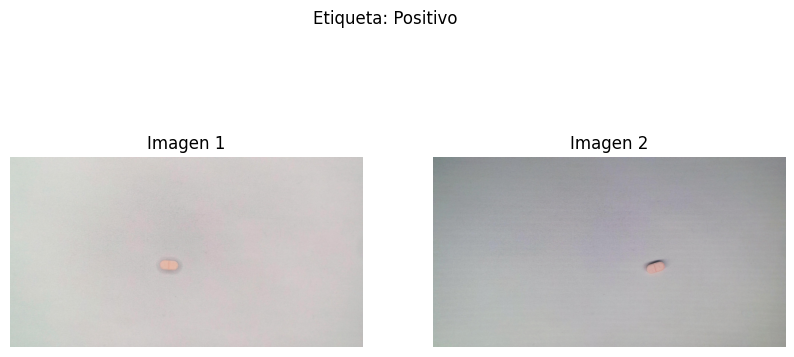

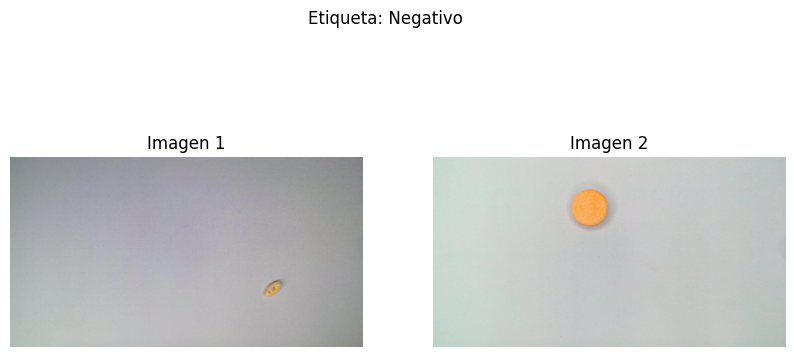

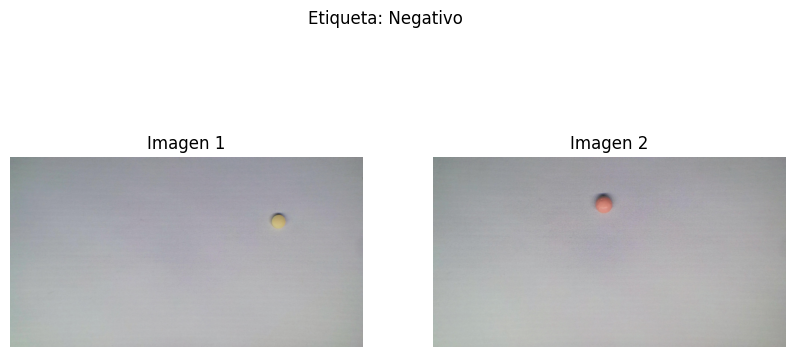

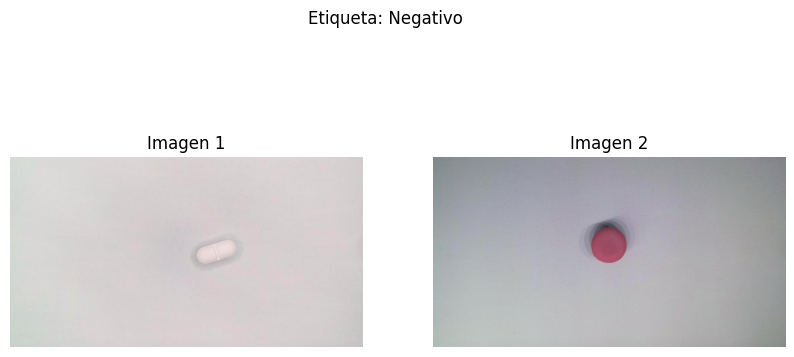

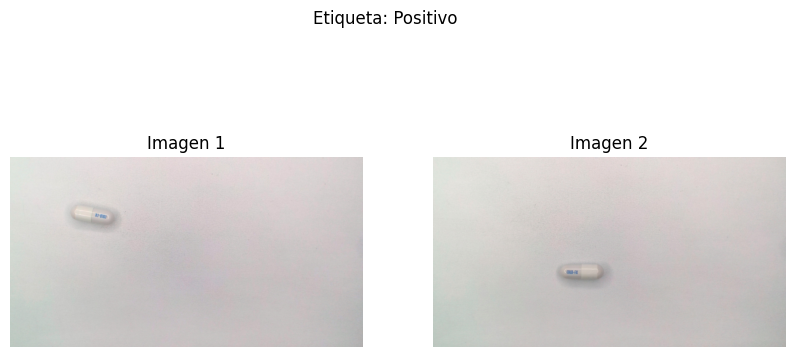

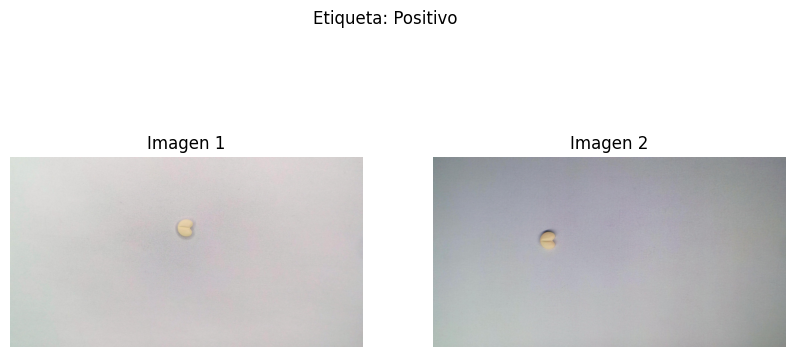

In [6]:
import matplotlib.pyplot as plt
import random

def show_sample(dataset):
    idx = random.randint(0, len(dataset) - 1)
    img1, img2, label = dataset[idx]
    img1 = img1.permute(1, 2, 0).numpy()
    img2 = img2.permute(1, 2, 0).numpy()
    

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(img1)
    axes[0].set_title("Imagen 1")

    axes[1].imshow(img2)
    axes[1].set_title("Imagen 2")

    plt.suptitle(f'Etiqueta: {"Positivo" if label.item() == 1 else "Negativo"}')

    for ax in axes:
        ax.axis('off')

    plt.show()

show_sample(train_dataset)

show_sample(train_dataset)

show_sample(train_dataset)

show_sample(train_dataset)

show_sample(train_dataset)

show_sample(train_dataset)



In [ ]:
train_dataset[0][0].shape

Se observa que las imagenes son de alta resolucion (2019, 3746) y solo una pequena porcion de la imagene esta ocupada por la pastilla. Esto hace que la red utilice un gran porcentaje de los computos a informacion irrelevante, ya que el fondo es siempre el mismo. 

Para resolver este problema, utilizaremos tecnicas clasicas para recortar la imagen al rededor de la pastilla, quedandonos solo con la region de interes. 

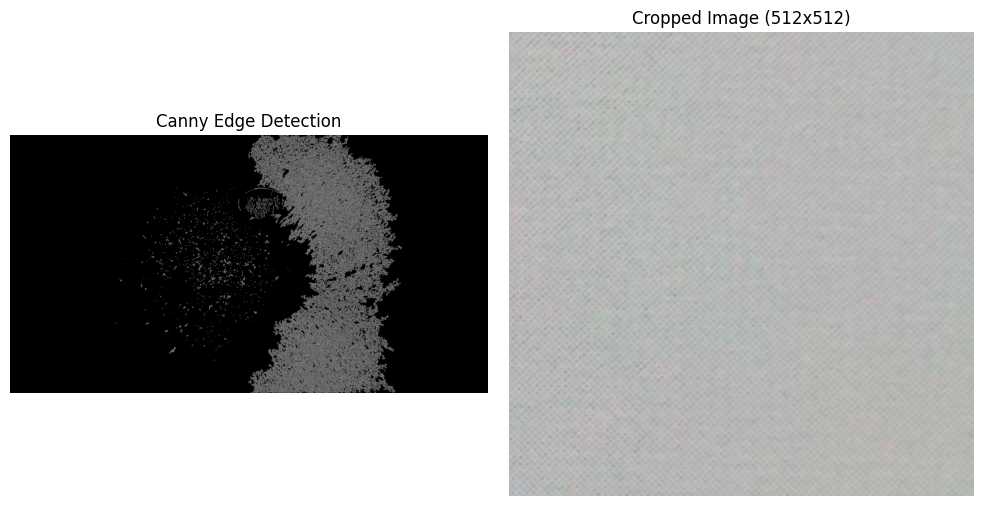

In [22]:
import cv2
from matplotlib import pyplot as plt

# Load the uploaded image
image_path = '../data/selected_split_data/test/advil_ultra_forte/advil_ultra_forte_u_003.jpg'
image = cv2.imread(image_path)

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Gaussian blur to smooth the image
#blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Apply Canny edge detector
edges = cv2.Canny(gray, threshold1=10, threshold2=200)

# Find contours based on edges
contours, _ = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Sort contours by area and get the largest one (which should be the pill)
contours = sorted(contours, key=cv2.contourArea, reverse=True)
pill_contour = contours[0]

# Get the bounding box of the largest contour
x, y, w, h = cv2.boundingRect(pill_contour)

# Define the center of the bounding box
center_x, center_y = x + w // 2, y + h // 2

# Define the 224x224 bounding box around the pill
start_x = max(0, center_x - 256)
start_y = max(0, center_y - 256)
end_x = min(image.shape[1], center_x + 256)
end_y = min(image.shape[0], center_y + 256)

# Crop the region around the pill
cropped_image = image[start_y:end_y, start_x:end_x]

# Plot the Canny edge detection result alongside the cropped image

plt.figure(figsize=(10, 5))

# Plot original image with Canny edges
plt.subplot(1, 2, 1)
plt.imshow(edges, cmap='gray')
plt.title("Canny Edge Detection")
plt.axis('off')

# Plot the cropped image around the pill
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
plt.title("Cropped Image (512x512)")
plt.axis('off')

plt.tight_layout()
plt.show()



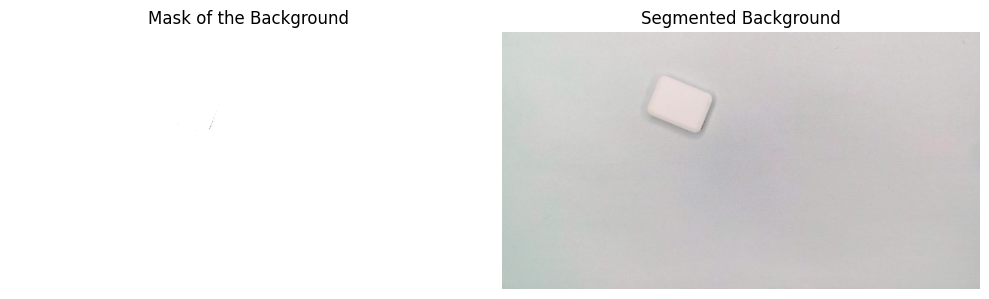

In [26]:
# Load the uploaded image
image_path = '../data/selected_split_data/test/mebucain_mint_2_mg_1_mg/mebucain_mint_2_mg_1_mg_u_005.jpg'
image = cv2.imread(image_path)

hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Define the color range for the background (light colors, near white)
lower_background = (0, 0, 150)
upper_background = (180, 50, 255)

# Create a mask to isolate the background
background_mask = cv2.inRange(hsv_image, lower_background, upper_background)

# Apply the mask to the original image to segment the background
segmented_background = cv2.bitwise_and(image, image, mask=background_mask)

# Display the mask and the segmented background image
plt.figure(figsize=(10, 5))

# Plot the mask
plt.subplot(1, 2, 1)
plt.imshow(background_mask, cmap='gray')
plt.title("Mask of the Background")
plt.axis('off')

# Plot the segmented background
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(segmented_background, cv2.COLOR_BGR2RGB))
plt.title("Segmented Background")
plt.axis('off')

plt.tight_layout()
plt.show()

Using cache found in /home/octadesh/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-9-29 Python-3.10.6 torch-2.0.1+cu117 CUDA:0 (NVIDIA GeForce GTX 1650, 3906MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


tensor([[8.52905e+02, 3.51437e+02, 1.09345e+03, 6.23468e+02, 4.39882e-01, 2.90000e+01]], device='cuda:0')


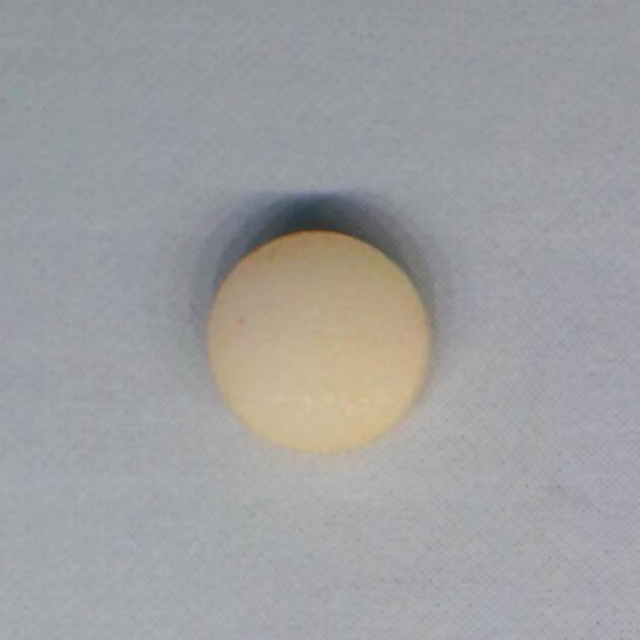

In [17]:
from PIL import Image
import torch
from transformers import DetrImageProcessor, DetrForObjectDetection
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Verificar si CUDA (GPU) está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Cargar imagen
img_path = '../data/failed_crop/lactamed_s_023.jpg'
image = Image.open(img_path)

# Cargar el modelo YOLOv5 pre-entrenado
model = torch.hub.load('ultralytics/yolov5', 'yolov5s').to(device)  

# Cargar imagen
image = Image.open(img_path)

# Realizar detección de objetos
results = model(img_path)

# Obtener los resultados
detections = results.xyxy[0]  # Las detecciones se encuentran aquí

# Mostrar imagen y bounding box
plt.figure(figsize=(10, 10))
plt.imshow(image)
ax = plt.gca()

print(detections)

if len(detections) > 0:
    # Obtener las coordenadas del primer bounding box
    xmin, ymin, xmax, ymax, conf, cls = detections[0]

    # Convertir a enteros
    xmin, ymin, xmax, ymax = map(int, [xmin, ymin, xmax, ymax])
    
    # Calcular el centro del bounding box
    center_x = (xmin + xmax) / 2
    center_y = (ymin + ymax) / 2
    
    # Dimensiones del recorte
    crop_size = 640
    
    # Calcular las coordenadas del recorte, asegurando que estén dentro de los límites de la imagen
    left = max(0, center_x - crop_size / 2)
    upper = max(0, center_y - crop_size / 2)
    right = min(image.width, center_x + crop_size / 2)
    lower = min(image.height, center_y + crop_size / 2)
    
    # Recortar la imagen
    cropped_image = image.crop((left, upper, right, lower))

cropped_image


Aplicaremos el modelo a todas las imagenes del dataset:

In [27]:
from PIL import Image
import torch
from transformers import DetrImageProcessor, DetrForObjectDetection
import os
from pathlib import Path


def create_cropped_path(original_path):
    # Split the original path
    path_parts = original_path.split(os.sep)

    # Replace 'selected_split_data' with 'cropped_selected_split_data'
    for i, part in enumerate(path_parts):
        if part == 'selected_split_data':
            path_parts[i] = 'cropped_selected_split_data'
            break

    # Join the parts back into a path
    new_path = os.sep.join(path_parts[:-1])  # Exclude the filename
    return new_path + os.sep 


def list_images(path):
    image_extensions = ('.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff')
    return [str(img) for img in Path(path).rglob('*') if img.suffix.lower() in image_extensions]


def crop_image(img_path, model, device):

    # Preprocesar la imagen
    model.conf = 0.03

    # Realizar detección de objetos
    results = model(img_path)

    detections = results.xyxy[0]
    
    if len(detections) > 0:
        # Obtener las coordenadas del primer bounding box
        xmin, ymin, xmax, ymax, conf, cls = detections[0]

        # Convertir a enteros
        xmin, ymin, xmax, ymax = map(int, [xmin, ymin, xmax, ymax])
        
        # Calcular el centro del bounding box
        center_x = (xmin + xmax) / 2
        center_y = (ymin + ymax) / 2
        
        # Dimensiones del recorte
        crop_size = 640
        
        # Calcular las coordenadas del recorte, asegurando que estén dentro de los límites de la imagen
        left = max(0, center_x - crop_size / 2)
        upper = max(0, center_y - crop_size / 2)
        right = min(image.width, center_x + crop_size / 2)
        lower = min(image.height, center_y + crop_size / 2)
        
        # Recortar la imagen
        cropped_image = image.crop((left, upper, right, lower))

        return cropped_image
    
    return None

In [28]:
from tqdm import tqdm
# Verificar si CUDA (GPU) está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Cargar modelo y procesador de Hugging Face
model = torch.hub.load('ultralytics/yolov5', 'yolov5s').to(device)  

path_to_images = '../data/selected_split_data'
path_list = list_images(path_to_images)
count=0

for image_path in tqdm(path_list):
    image_name = image_path.split('/')[-1]
    image = Image.open(image_path)
    cropped_image = crop_image(image_path, model, device)

    if cropped_image is not None:
        new_path = create_cropped_path(image_path)
        

        full_path = os.path.join(new_path, image_name)

        os.makedirs(new_path, exist_ok=True)

        cropped_image.save(full_path)

        count+=1
    else:
        image.save(f"../data/failed_crop/{image_name}")

print(f"De un total de {len(path_list)} se procesaron {count} correctamente")

Using cache found in /home/octadesh/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-9-29 Python-3.10.6 torch-2.0.1+cu117 CUDA:0 (NVIDIA GeForce GTX 1650, 3906MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 
100%|██████████| 1136/1136 [02:04<00:00,  9.11it/s]

De un total de 1136 se procesaron 1097 correctamente


In [ ]:
# Hacemos lo mismo para las clases no utilizadas durante entrenamiento:

from tqdm import tqdm
# Verificar si CUDA (GPU) está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Cargar modelo y procesador de Hugging Face
model = torch.hub.load('ultralytics/yolov5', 'yolov5s').to(device)  

path_to_images = '../data/not_used_classes'
path_list = list_images(path_to_images)
count=0

for image_path in tqdm(path_list):
    image_name = image_path.split('/')[-1]
    image = Image.open(image_path)
    cropped_image = crop_image(image_path, model, device)

    if cropped_image is not None:
        new_path = create_cropped_path(image_path)
        

        full_path = os.path.join(new_path, image_name)

        os.makedirs(new_path, exist_ok=True)

        cropped_image.save(full_path)

        count+=1
    else:
        image.save(f"../data/failed_crop/{image_name}")

print(f"De un total de {len(path_list)} se procesaron {count} correctamente")